<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import os
import math
import statistics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

In [30]:
# Parameter for data
## Security code
stock_code='ECL'
## Start Date
start_date='2015-08-17'
## End Date
end_date='2023-08-18'
## Split ratio of train data and validation data
train_rate=0.8
## How many business days to see
input_window_size=60
## How many business days to predict
predict_period_num=1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)['Adj Close'].to_frame()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2015-08-17,106.413971
2015-08-18,106.002380
2015-08-19,105.051239
2015-08-20,103.002502
2015-08-21,100.514786


# Normalize the data

In [31]:
# Normalization and Denormalization constants
denorm_const = df['Adj Close'].iloc[0]
norm_const = 1/denorm_const

denorm_const, norm_const

(106.41397094726562, 0.009397262324658092)

In [32]:
# Normalize
df = df*norm_const
df.head()

,Adj Close
Date,
2015-08-17,1.000000
2015-08-18,0.996132
2015-08-19,0.987194
2015-08-20,0.967942
2015-08-21,0.944564


# Bollinger Bands

In [33]:
def get_rolling_mean(df_, window):
    return df_.rolling(window).mean()

def get_rolling_std(df_, window):
    return df_.rolling(window).std()

def get_bollinger_bands(rm, rstd):
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

def clip_to_bollinger_bands(df_, window):
    rm = get_rolling_mean(df_, window=window)
    rstd = get_rolling_std(df_, window=window)
    upper_band, lower_band = get_bollinger_bands(rm, rstd)
    return df_.clip(upper=upper_band, lower=lower_band)

In [34]:
def plot_df(df, title="Default Title"):
    ax = df.plot()
    ax.set_xlabel(title)
    ax.get_legend().remove()
    plt.show()

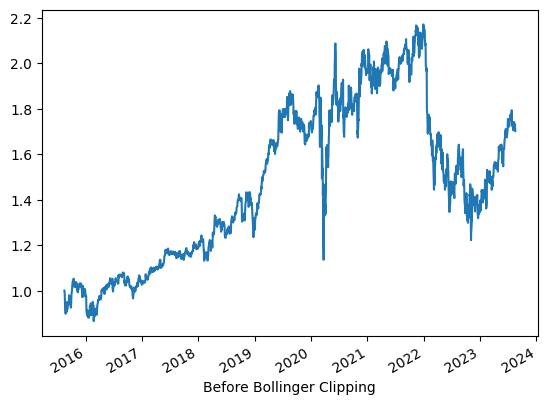

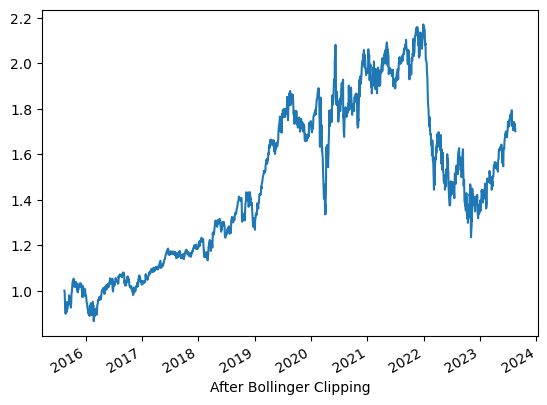

In [35]:
plot_df(df, "Before Bollinger Clipping")
df = clip_to_bollinger_bands(df, input_window_size)
plot_df(df, "After Bollinger Clipping")

After Bollinger Clipping we have first (input_window_size - 1) elements as NaN

In [36]:
df.head(15)

,Adj Close
Date,
2015-08-17,1.000000
2015-08-18,0.996132
2015-08-19,0.987194
2015-08-20,0.967942
2015-08-21,0.944564
2015-08-24,0.905458
2015-08-25,0.898410
2015-08-26,0.915256
2015-08-27,0.944736


In [37]:
data = list(df['Adj Close'])
len(data)

2015

# Train, Validation and Test data

For DNN

Train+Validation : Test = 80 : 20

In [38]:
train_till = int(0.8*len(data))  # this is train + validation

train_raw_data = data[:train_till]
test_raw_data = data[train_till:]

train_features = [train_raw_data[i:i+input_window_size] for i in range(len(train_raw_data)-input_window_size)]
test_features = [test_raw_data[i:i+input_window_size] for i in range(len(test_raw_data)-input_window_size)]

train_labels = train_raw_data[input_window_size:]
test_labels = test_raw_data[input_window_size:]

print(len(train_features), len(train_labels))
print(len(test_features), len(test_labels))

1552 1552
343 343


In [39]:
train_features = pd.DataFrame.from_records(train_features)
test_features = pd.DataFrame.from_records(test_features)

train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(1552, 60) (1552, 1)
(343, 60) (343, 1)


# Build the model

In [40]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[input_window_size]),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [41]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                3904      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


# Train the model

Without Early Stopping

In [42]:
n_epochs = 100
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print()
        print('.', end='')

history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[PrintDot()])


..................................................
..................................................

In [43]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.001054,0.002753,95
96,0.001097,0.002090,96
97,0.000918,0.001072,97
98,0.000937,0.001122,98
99,0.000849,0.001256,99


In [44]:
hist.head()

,loss,val_loss,epoch
0,0.251184,0.017514,0
1,0.008423,0.006371,1
2,0.006908,0.006337,2
3,0.006746,0.006206,3
4,0.006494,0.006399,4


In [45]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Loss  x($10^{-6}$)')
    plt.ylabel('Loss')
    # plt.plot(hist['epoch'], hist['loss']*1000000, label='Train Loss')
    # plt.plot(hist['epoch'], hist['val_loss']*1000000, label='Validation Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    # plt.ylim([0, 500])
    plt.legend()

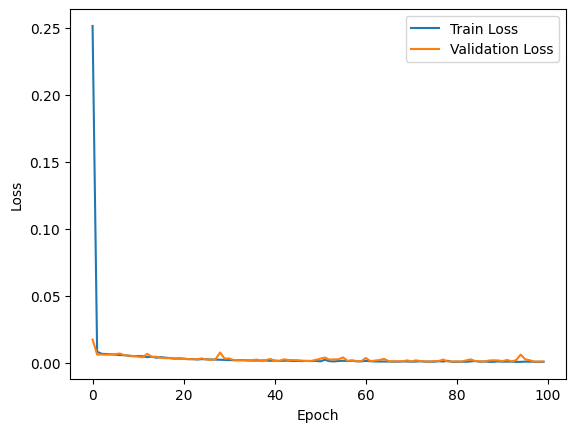

In [46]:
plot_history(history)

With Early Stopping


..................................................
...

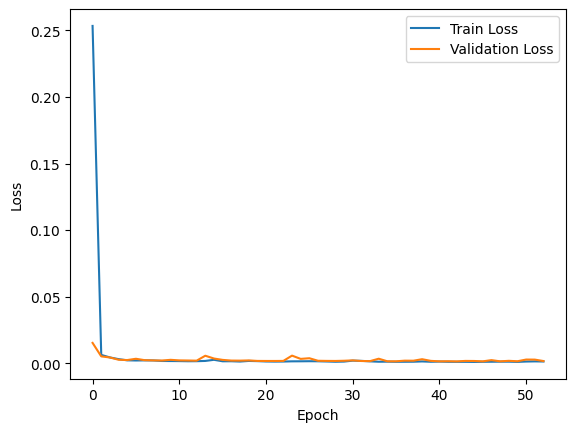

In [47]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

# Test on test data

In [48]:
loss = model.evaluate(test_features, test_labels)
print("Mean Squared Error on test data = {}".format(loss))

11/11 [==============================] - 0s 2ms/step - loss: 0.0023
Mean Squared Error on test data = 0.002284923568367958


# Make Predictions

In [49]:
test_predictions = model.predict(test_features)
test_predictions.shape

11/11 [==============================] - 0s 1ms/step


(343, 1)

In [50]:
test_predictions[:10]

array([[1.7592614],
       [1.7486181],
       [1.7387371],
       [1.7318597],
       [1.7181885],
       [1.6975068],
       [1.7133892],
       [1.7088108],
       [1.6845543],
       [1.6908666]], dtype=float32)

In [51]:
test_predictions[:10]

array([[1.7592614],
       [1.7486181],
       [1.7387371],
       [1.7318597],
       [1.7181885],
       [1.6975068],
       [1.7133892],
       [1.7088108],
       [1.6845543],
       [1.6908666]], dtype=float32)

In [52]:
#plt.figure()
#plt.xlabel('Days')
#plt.ylabel('Stock Price')
#plt.plot(test_predictions*denorm_const, 'g', label='Prediction')
#plt.plot(test_labels[0]*denorm_const, 'r', label='Actual')
#plt.legend()
#plt.show()

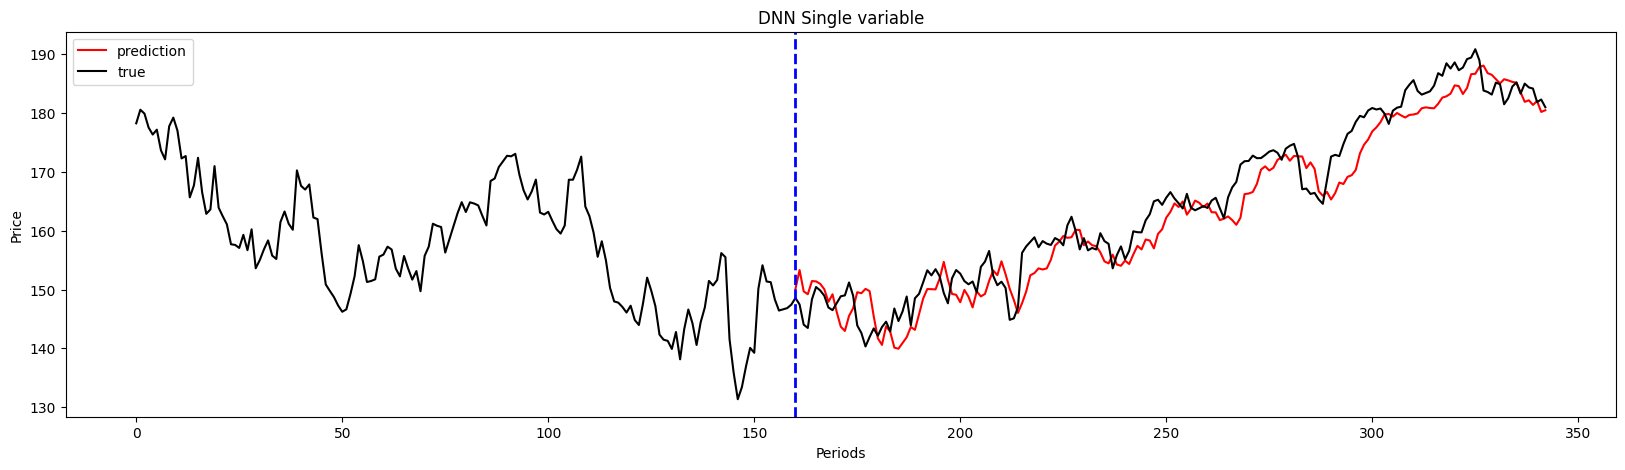

In [54]:
import matplotlib.pyplot as pyplot
fig = pyplot.figure(1, figsize=(20, 5))
fig.patch.set_facecolor('xkcd:white')
pyplot.plot([k + 160 for k in range(183)],test_predictions[160:]*denorm_const,color="red")
pyplot.title('DNN Single variable')
pyplot.plot(test_labels[0]*denorm_const,color="black")
pyplot.legend(["prediction", "true"], loc="upper left")
ymin, ymax = pyplot.ylim()
pyplot.vlines(160, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
pyplot.ylim(ymin, ymax)
pyplot.xlabel("Periods")
pyplot.ylabel("Price")
pyplot.show()
pyplot.close()